In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

from matplotlib.pyplot import imshow

%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


### 载入数据集

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# 载入数据集 (手势)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

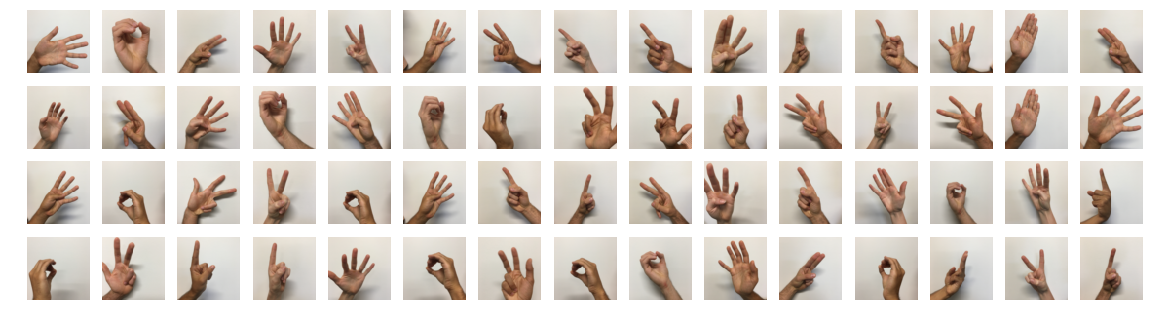

In [4]:
# 绘制训练样本图片集 前60张
X_orig = X_train_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

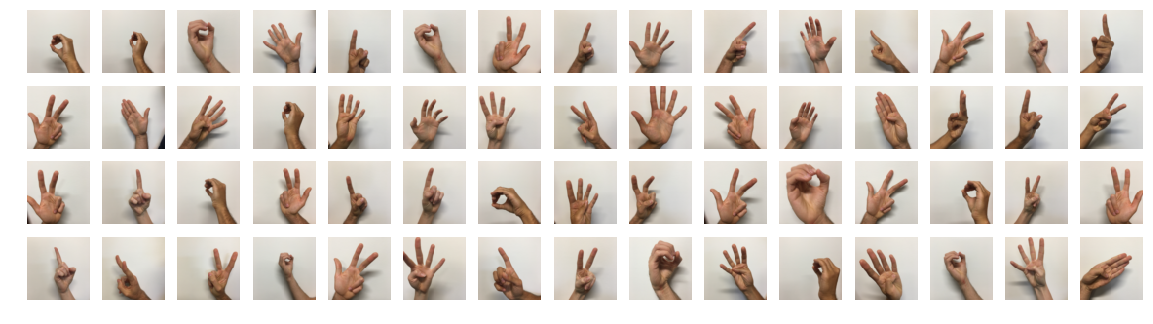

In [5]:
# 绘制测试样本图片集 前60张
X_orig = X_test_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

### 标准化输入

In [6]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = np.eye(6)[Y_train_orig.reshape(-1)]
Y_test = np.eye(6)[Y_test_orig.reshape(-1)]

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 构建残差块

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

In [7]:
# Identity block. Skip connection "skips over" 3 layers.
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    relu_name_base = 'relu' + str(stage) + block + '_branch'
    add_name_base = 'add' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu', name = relu_name_base + '2a')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', 
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2b')(X)
    X = Activation('relu', name = relu_name_base + '2b')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis=3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.add([X, X_shortcut], name = add_name_base + '3')
    X = Activation('relu', name = relu_name_base + '3')(X)
    
    return X

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **Convolutional block** </center></caption>

In [8]:
# Convolutional block
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    relu_name_base = 'relu' + str(stage) + block + '_branch'
    add_name_base = 'add' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding='valid', 
               kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu', name = relu_name_base + '2a')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + '2b',padding='same', 
               kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu', name = relu_name_base + '2b')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1, 1), name = conv_name_base + '2c',padding='valid', 
               kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), name = conv_name_base + '1',padding='valid', 
                        kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = layers.add([X, X_shortcut], name = add_name_base + '3')
    X = Activation('relu', name = relu_name_base + '3')(X)
    
    return X

### 构建残差网络

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

In [9]:
# Implementation of the popular ResNet50 the following architecture:
# CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3 -> 
# CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
def MyResNet50(input_shape = (64, 64, 3), classes = 6):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape, name = 'input')
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3), name = 'zero_padding2d')(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu', name = 'relu1')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), name = 'max_pooling2d1')(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    # AVGPOOL
    X = AveragePooling2D(pool_size = (2,2), name = 'avg_pool')(X) # 标准输入时 pool_size = (4,4)
    
    # output layer
    X = Flatten(name = 'flatten')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform())(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [10]:
model = MyResNet50(input_shape = (64, 64, 3), classes = 6)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
relu1 (Act

### 训练模型

In [13]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_split=0.1)

Train on 972 samples, validate on 108 samples
Epoch 1/20
972/972 [==============================] - 154s 158ms/step - loss: 2.1318 - acc: 0.3570 - val_loss: 1.2438 - val_acc: 0.4259
Epoch 2/20
972/972 [==============================] - 147s 151ms/step - loss: 0.8336 - acc: 0.6584 - val_loss: 0.8261 - val_acc: 0.6481
Epoch 3/20
972/972 [==============================] - 150s 154ms/step - loss: 0.4485 - acc: 0.8261 - val_loss: 0.6088 - val_acc: 0.7130
Epoch 4/20
972/972 [==============================] - 145s 149ms/step - loss: 0.4226 - acc: 0.8447 - val_loss: 0.4266 - val_acc: 0.8796
Epoch 5/20
972/972 [==============================] - 141s 145ms/step - loss: 0.2220 - acc: 0.9177 - val_loss: 0.3321 - val_acc: 0.8981
Epoch 6/20
972/972 [==============================] - 150s 155ms/step - loss: 0.1220 - acc: 0.9547 - val_loss: 0.4564 - val_acc: 0.8519
Epoch 7/20
972/972 [==============================] - 147s 151ms/step - loss: 0.1930 - acc: 0.9414 - val_loss: 0.5709 - val_acc: 0.8333
Ep

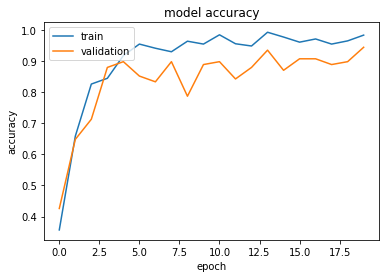

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

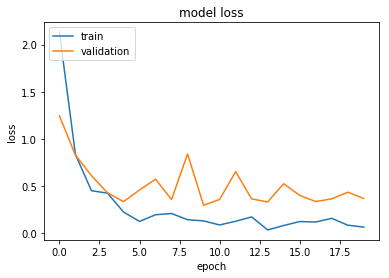

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 评估模型

In [16]:
preds = model.evaluate(x=X_test, y=Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 4s 34ms/step
Loss = 0.2801408718029658
Test Accuracy = 0.9083333293596904
